# 前処理

In [1]:
import dask
import re
import dask
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime

#air
#reserve
df_air_reserve=pd.read_csv('~/Desktop/ml/restaurant_vistor/air_reserve.csv')
df_air_reserve['visit_date']=df_air_reserve['visit_datetime'].str.split().str[0]
df_air_reserve['visit_time']=df_air_reserve['visit_datetime'].str.split().str[1]
df_air_reserve['reserve_date']=df_air_reserve['reserve_datetime'].str.split().str[0]
df_air_reserve['reserve_time']=df_air_reserve['reserve_datetime'].str.split().str[1]
# group by store_id & visit_date
df_air_reserve_grouped=df_air_reserve.groupby(['air_store_id','visit_date']).sum()
df_air_reserve_grouped=df_air_reserve_grouped.reset_index()

#store info
df_air_store_info=pd.read_csv('~/Desktop/ml/restaurant_vistor/air_store_info.csv')

#visit
df_air_visit_data=pd.read_csv('~/Desktop/ml/restaurant_vistor/air_visit_data.csv')

#date info
df_date_info=pd.read_csv('~/Desktop/ml/restaurant_vistor/date_info.csv')

# join tables df_air_reserve_grouped, df_air_store_info & df_air_visit_data
df_air=df_air_reserve_grouped.merge(df_air_store_info, left_on='air_store_id', right_on='air_store_id', how='outer')
df_air=df_air.merge(df_air_visit_data, left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_date'], how='outer')

# join date_info
df_air=df_air.merge(df_date_info, left_on=['visit_date'], right_on=['calendar_date'], how='left')

df_air.drop(columns='calendar_date', inplace=True)

#hpg
# reserve & visit data
df_hpg_reserve=pd.read_csv('~/Desktop/ml/restaurant_vistor/hpg_reserve.csv')
df_hpg_reserve['visit_date']=df_hpg_reserve['visit_datetime'].str.split().str[0]
df_hpg_reserve['visit_time']=df_hpg_reserve['visit_datetime'].str.split().str[1]
df_hpg_reserve['reserve_date']=df_hpg_reserve['reserve_datetime'].str.split().str[0]
df_hpg_reserve['reserve_time']=df_hpg_reserve['reserve_datetime'].str.split().str[1]
# group by store_id & visit_date
df_hpg_reserve_grouped=df_hpg_reserve.groupby(['hpg_store_id', 'visit_date']).sum()
df_hpg_reserve_grouped=df_hpg_reserve_grouped.reset_index()

#store info
df_hpg_store_info=pd.read_csv('~/Desktop/ml/restaurant_vistor/hpg_store_info.csv')

# join tables df_hpg_reserve & df_hpg_store_info
df_hpg=df_hpg_reserve_grouped.merge(df_hpg_store_info, on='hpg_store_id', how='outer')

# join air & hpg
df_store_id_relation=pd.read_csv('~/Desktop/ml/restaurant_vistor/store_id_relation.csv')
df=df_air.merge(df_store_id_relation, on='air_store_id', how='left')
df=df.merge(df_hpg, on=['hpg_store_id', 'visit_date'], how='left')

# drop unecessary columns
df.drop(columns=['reserve_visitors_x', 'reserve_visitors_y', 'latitude_x', 'latitude_y', 'longitude_x', 'longitude_y'], inplace=True)
df.drop(columns=['hpg_store_id', 'hpg_genre_name', 'hpg_area_name'], inplace=True)

# change date format to datetime
df['visit_date']=pd.to_datetime(df['visit_date'])

In [2]:
df.head(5)

,air_store_id,visit_date,air_genre_name,air_area_name,visitors,day_of_week,holiday_flg
0,air_00a91d42b08b08d9,2016-10-31,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,26.0,Monday,0.0
1,air_00a91d42b08b08d9,2016-12-05,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,33.0,Monday,0.0
2,air_00a91d42b08b08d9,2016-12-14,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,30.0,Wednesday,0.0
3,air_00a91d42b08b08d9,2016-12-17,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,17.0,Saturday,0.0
4,air_00a91d42b08b08d9,2016-12-20,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,37.0,Tuesday,0.0


# time series framework
### colection period: 4 weeks
### validation periad: 1 week
### move window by 1 week

In [3]:
col_s=datetime.datetime(2016, 7, 1)
last_col_s=datetime.datetime(2016,11,25)

while(col_s<=last_col_s):
    end_date = col_s + datetime.timedelta(days=10)
    col_e=col_s + datetime.timedelta(days=27)
    val_s=col_s + datetime.timedelta(days=28)
    val_e=col_s + datetime.timedelta(days=34)

    print(col_s, col_e, val_s, val_e)
    col_s=col_s + datetime.timedelta(days=7)

2016-07-01 00:00:00 2016-07-28 00:00:00 2016-07-29 00:00:00 2016-08-04 00:00:00
2016-07-08 00:00:00 2016-08-04 00:00:00 2016-08-05 00:00:00 2016-08-11 00:00:00
2016-07-15 00:00:00 2016-08-11 00:00:00 2016-08-12 00:00:00 2016-08-18 00:00:00
2016-07-22 00:00:00 2016-08-18 00:00:00 2016-08-19 00:00:00 2016-08-25 00:00:00
2016-07-29 00:00:00 2016-08-25 00:00:00 2016-08-26 00:00:00 2016-09-01 00:00:00
2016-08-05 00:00:00 2016-09-01 00:00:00 2016-09-02 00:00:00 2016-09-08 00:00:00
2016-08-12 00:00:00 2016-09-08 00:00:00 2016-09-09 00:00:00 2016-09-15 00:00:00
2016-08-19 00:00:00 2016-09-15 00:00:00 2016-09-16 00:00:00 2016-09-22 00:00:00
2016-08-26 00:00:00 2016-09-22 00:00:00 2016-09-23 00:00:00 2016-09-29 00:00:00
2016-09-02 00:00:00 2016-09-29 00:00:00 2016-09-30 00:00:00 2016-10-06 00:00:00
2016-09-09 00:00:00 2016-10-06 00:00:00 2016-10-07 00:00:00 2016-10-13 00:00:00
2016-09-16 00:00:00 2016-10-13 00:00:00 2016-10-14 00:00:00 2016-10-20 00:00:00
2016-09-23 00:00:00 2016-10-20 00:00:00 

# prepare learning and validation data

In [4]:
# example: first loop
col_s=datetime.datetime(2016, 7, 1)
col_e=col_s + datetime.timedelta(days=27)
val_s=col_s + datetime.timedelta(days=28)
val_e=col_s + datetime.timedelta(days=34)

df_learn=df[(col_s<=df['visit_date']) & (df['visit_date']<=col_e)]
df_validate=df[(val_s<=df['visit_date']) & (df['visit_date']<=val_e)]

In [5]:
print(col_s, col_e, val_s, val_e)

2016-07-01 00:00:00 2016-07-28 00:00:00 2016-07-29 00:00:00 2016-08-04 00:00:00


In [6]:
df_learn.sort_values(by=['air_store_id', 'visit_date']).head(10)

,air_store_id,visit_date,air_genre_name,air_area_name,visitors,day_of_week,holiday_flg
104428,air_00a91d42b08b08d9,2016-07-01,NaN,NaN,35.0,Friday,0.0
104429,air_00a91d42b08b08d9,2016-07-02,NaN,NaN,9.0,Saturday,0.0
104430,air_00a91d42b08b08d9,2016-07-04,NaN,NaN,20.0,Monday,0.0
104431,air_00a91d42b08b08d9,2016-07-05,NaN,NaN,25.0,Tuesday,0.0
104432,air_00a91d42b08b08d9,2016-07-06,NaN,NaN,29.0,Wednesday,0.0
104433,air_00a91d42b08b08d9,2016-07-07,NaN,NaN,34.0,Thursday,0.0
104434,air_00a91d42b08b08d9,2016-07-08,NaN,NaN,42.0,Friday,0.0
104435,air_00a91d42b08b08d9,2016-07-09,NaN,NaN,11.0,Saturday,0.0
104436,air_00a91d42b08b08d9,2016-07-11,NaN,NaN,25.0,Monday,0.0
104437,air_00a91d42b08b08d9,2016-07-12,NaN,NaN,24.0,Tuesday,0.0


In [7]:
df_validate.sort_values(['air_store_id', 'visit_date']).head(10)

,air_store_id,visit_date,air_genre_name,air_area_name,visitors,day_of_week,holiday_flg
104451,air_00a91d42b08b08d9,2016-07-29,NaN,NaN,31.0,Friday,0.0
104452,air_00a91d42b08b08d9,2016-07-30,NaN,NaN,20.0,Saturday,0.0
104453,air_00a91d42b08b08d9,2016-08-01,NaN,NaN,16.0,Monday,0.0
104454,air_00a91d42b08b08d9,2016-08-02,NaN,NaN,24.0,Tuesday,0.0
104455,air_00a91d42b08b08d9,2016-08-03,NaN,NaN,30.0,Wednesday,0.0
104456,air_00a91d42b08b08d9,2016-08-04,NaN,NaN,30.0,Thursday,0.0
234569,air_0241aa3964b7f861,2016-07-29,NaN,NaN,3.0,Friday,0.0
234570,air_0241aa3964b7f861,2016-07-30,NaN,NaN,13.0,Saturday,0.0
234571,air_0241aa3964b7f861,2016-07-31,NaN,NaN,3.0,Sunday,0.0
234572,air_0241aa3964b7f861,2016-08-01,NaN,NaN,13.0,Monday,0.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


[]

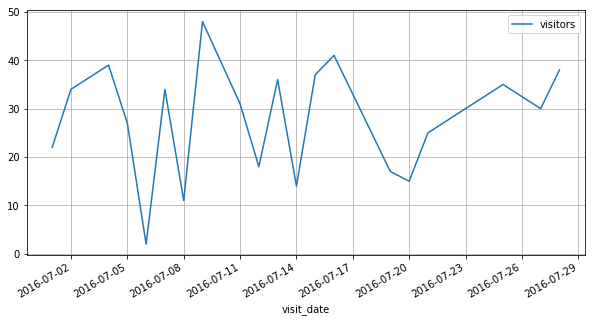

In [8]:
ax=df_learn[df['air_store_id']=='air_0a74a5408a0b8642'].plot(x='visit_date', y='visitors', figsize=(10,5), grid=True)
ax.plot()

# 学習してみる

In [9]:
df_preprocessed=pd.read_csv('~/Desktop/ml/restaurant_vistor/preprocessed_data.csv')

In [10]:
# change date format to datetime
df_preprocessed['visit_date']=pd.to_datetime(df_preprocessed['visit_date'])
df_preprocessed.drop(columns='Unnamed: 0', inplace=True)

In [66]:
#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [85]:
col_s=datetime.datetime(2016, 7, 1)
last_col_s=datetime.datetime(2016,11,25)

while(col_s<=last_col_s):
    end_date = col_s + datetime.timedelta(days=10)
    col_e=col_s + datetime.timedelta(days=27)
    val_s=col_s + datetime.timedelta(days=28)
    val_e=col_s + datetime.timedelta(days=34)

    # print(col_s, col_e, val_s, val_e)
    
    df_learn_test=df_preprocessed[(col_s<=df_preprocessed['visit_date']) & (df_preprocessed['visit_date']<=col_e) & (df_preprocessed['air_store_id']=='air_0241aa3964b7f861')]
    df_validate_test=df_preprocessed[(val_s<=df_preprocessed['visit_date']) & (df_preprocessed['visit_date']<=val_e) & (df_preprocessed['air_store_id']=='air_0241aa3964b7f861')]

    X_train=df_learn_test.drop(columns=['air_store_id', 'visitors', 'visit_date'])
    y_train=df_learn_test['visitors']
    X_test=df_validate_test.drop(columns=['air_store_id', 'visitors', 'visit_date'])
    y_test=df_validate_test['visitors']
    
    reg = LinearRegression().fit(X_train, y_train)
    #y_predict = reg.predict(X_test)
    #reg.score(X_test, y_test)
    print(col_s)
    print(reg.predict(X_test), y_test.values)
    
    col_s=col_s + datetime.timedelta(days=7)

2016-07-01 00:00:00
[-17.   29.   13.5   6.5   9.5   7.5] [ 3. 13.  3. 13. 13. 14.]
2016-07-08 00:00:00
[ 3.72566163 11.97566163  9.13610586  8.56616257  5.29820416 17.65642722] [ 5.  9.  1. 10. 10.  8.]
2016-07-15 00:00:00
[7.         7.25855279 8.85860202] [11. 10. 13.]
2016-07-22 00:00:00
[ 5.36904762 11.03571429  7.10714286  7.54761905  7.67857143 11.46428571] [ 7. 27. 18.  5.  8.  7.]
2016-07-29 00:00:00
[ 2.77777778 14.11111111  7.          8.66666667  8.33333333  9.11111111] [ 7. 11.  9.  6. 12.  9.]
2016-08-05 00:00:00
[ 3.00649351 12.33982684  7.57142857  5.23809524  6.84415584  5.45887446] [10.  6. 12. 13. 13.  3.]
2016-08-12 00:00:00
[ 6.31028369 12.97695035 18.5212766  14.89095745 12.14095745] [ 2. 11.  8.  7.  9.]
2016-08-19 00:00:00
[15.66158537 13.47560976 11.72560976  6.67276423] [34. 17.  2. 11.]
2016-08-26 00:00:00
[ 6.81881736 15.07835712  8.88552287  9.86411302  7.11054471  6.17127876] [22.  6. 26.  9.  6. 10.]
2016-09-02 00:00:00
[14.77949315 11.68577046 11.6745557